# Bureau Balance Analysis

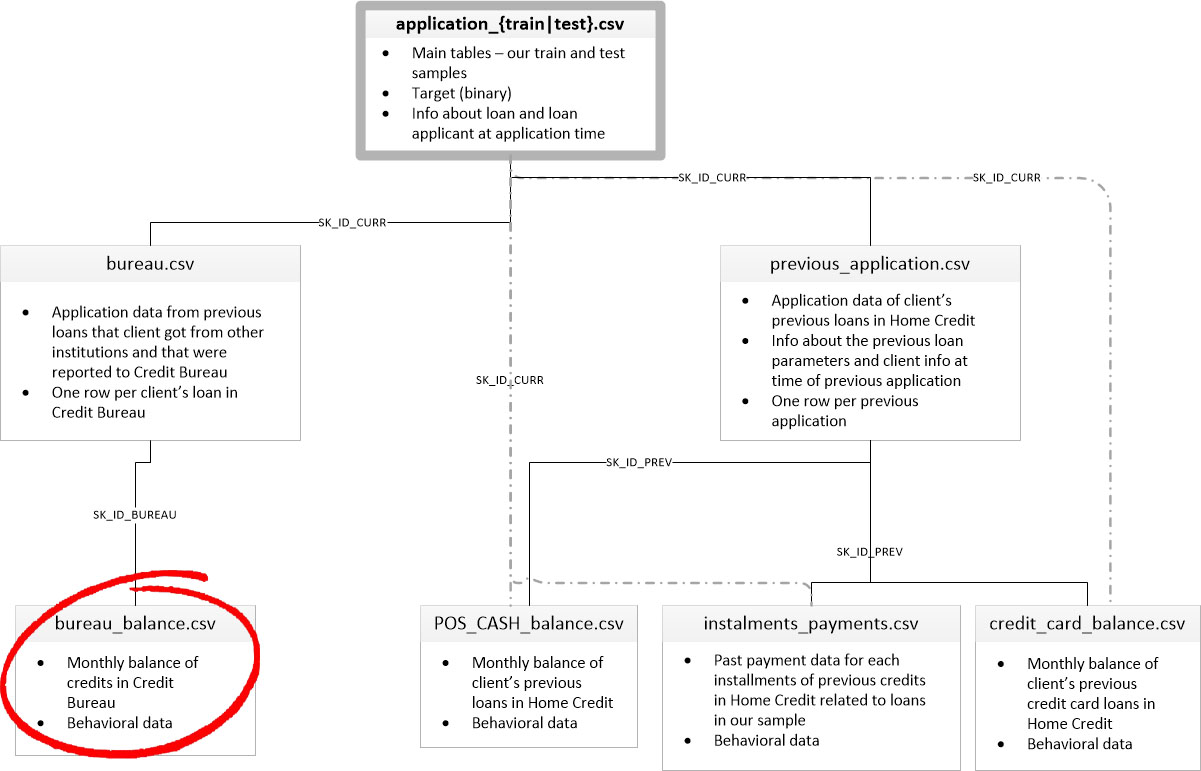

In this notebook I will try to explore bureau balance dataset and see what we can take from it.

Here is a short description from home credit about this dataset:
* "Monthly balances of previous credits in Credit Bureau."
* "This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows."

# Import Libraries

In [1]:
%load_ext nb_black
import homecredit_functions as hc
import imp

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sns.set(style="whitegrid", color_codes=True)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

RANDOM_STATE = 0

<IPython.core.display.Javascript object>

# Load Processed Application And Bureau Datasets

### Application Test Processed Dataset

In [2]:
path_application_test_proc = "data/application_test_proc.csv"
df_application_test_proc = pd.read_csv(path_application_test_proc)

<IPython.core.display.Javascript object>

In [3]:
df_application_test_proc.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,EXT_SOURCE_MIN,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,SK_ID_CURR
0,0.00000,0.00093,0.13079,0.25700,0.33754,0.04067,0.79045,0.88718,1.00000,1.00000,...,0.18150,0.13697,0.40086,0.11915,0.14272,0.03929,0.09607,0.99961,0.95603,100001
1,0.00000,0.00063,0.04439,0.49159,0.40389,0.03509,0.63043,0.77449,1.00000,1.00000,...,0.33184,0.43293,0.12210,0.25106,0.05407,0.02141,0.09867,0.99981,0.96073,100005
2,0.00000,0.00151,0.15437,0.26048,0.29262,0.03511,0.91184,0.51327,1.00000,1.00000,...,0.69517,0.62560,0.05975,0.03404,0.04381,0.03667,0.12049,0.99933,0.84987,100013
3,0.10526,0.00247,0.38202,0.36143,0.63433,0.04188,0.91894,0.41531,1.00000,1.00000,...,0.57990,0.10142,0.48475,0.05532,0.22152,0.05896,0.12821,0.99889,0.84877,100028
4,0.05263,0.00132,0.14494,0.13490,0.68709,0.04103,0.83787,0.40781,1.00000,1.00000,...,0.23000,0.24395,0.24761,0.23404,0.12441,0.04097,0.12821,0.99937,0.89487,100038


<IPython.core.display.Javascript object>

### Application Train Processed Dataset

In [4]:
path_application_train_proc = "data/application_train_proc.csv"
df_application_train_proc = pd.read_csv(path_application_train_proc)

<IPython.core.display.Javascript object>

In [5]:
df_application_train_proc.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,ANNUITY_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,TARGET_NEIGHBORS_500_MEAN,GOODS_PRICE_AMT_ANNUITY_RATIO,GOODS_PRICE_AMT_INCOME_TOTAL_RATIO,GOODS_PRICE_AMT_CREDIT_RATIO,ANNUITY_DAYS_EMPLOYED_RATIO,ANNUITY_DAYS_BIRTH_RATIO,TARGET,SK_ID_CURR
0,0.00000,0.00151,0.09029,0.25632,0.88884,0.04509,0.85214,0.70543,1.00000,1.00000,...,0.31105,0.19041,0.54468,0.08367,0.02041,0.10717,0.99838,0.88820,1,100002
1,0.00000,0.00209,0.31174,0.04502,0.47711,0.04365,0.95193,0.95957,1.00000,1.00000,...,0.07648,0.56183,0.08511,0.21774,0.04932,0.10870,0.99874,0.90937,0,100003
2,0.00000,0.00036,0.02247,0.13490,0.34853,0.04616,0.82733,0.64833,1.00000,1.00000,...,0.23499,0.25688,0.05532,0.12821,0.02356,0.12821,0.99874,0.98744,0,100004
3,0.00000,0.00093,0.06684,0.10702,0.35085,0.03882,0.60145,0.66139,1.00000,1.00000,...,0.55299,0.07905,0.06809,0.05132,0.02592,0.12049,0.99957,0.93432,0,100006
4,0.00000,0.00082,0.11685,0.39288,0.29859,0.03882,0.82527,0.51952,1.00000,1.00000,...,0.18279,0.32191,0.15319,0.15483,0.04978,0.12821,0.99968,0.95478,0,100007


<IPython.core.display.Javascript object>

### Bureau Dataset

In [6]:
path_bureau = "data/bureau.csv"
df_bureau = pd.read_csv(path_bureau)

<IPython.core.display.Javascript object>

In [7]:
df_bureau.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00000,-153.00000,nan,0,91323.00000,0.00000,nan,0.00000,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,1075.00000,nan,nan,0,225000.00000,171342.00000,nan,0.00000,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.00000,nan,nan,0,464323.50000,nan,nan,0.00000,Consumer credit,-16,nan
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,90000.00000,nan,nan,0.00000,Credit card,-16,nan
4,215354,5714466,Active,currency 1,-629,0,1197.00000,nan,77674.50000,0,2700000.00000,nan,nan,0.00000,Consumer credit,-21,nan


<IPython.core.display.Javascript object>

# EDA

### Bureau Balance Dataset

In [8]:
path_bureau_bal = "data/bureau_balance.csv"
df_bureau_bal = pd.read_csv(path_bureau_bal)

<IPython.core.display.Javascript object>

In [9]:
df_bureau_bal

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


<IPython.core.display.Javascript object>

In [10]:
df_bureau_bal.select_dtypes(["float64", "int64"]).describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_BUREAU,27299925.00000,6036297.33297,492348.85690,5001709.00000,5730933.00000,6070821.00000,6431951.00000,6842888.00000
MONTHS_BALANCE,27299925.00000,-30.74169,23.86451,-96.00000,-46.00000,-25.00000,-11.00000,0.00000


<IPython.core.display.Javascript object>

In [11]:
df_bureau_bal.select_dtypes(["object"]).describe().T

,count,unique,top,freq
STATUS,27299925,8,C,13646993


<IPython.core.display.Javascript object>

**Observation:**:
* Dataset has just two columns: one numerical and other categorical.
* Seems that there is no singificant max values and categorical features doesn't have too many unique classes.

In [12]:
# Add SK_ID_CURR column
df_bureau_bal = df_bureau_bal.merge(
    df_bureau[["SK_ID_CURR", "SK_ID_BUREAU"]], how="left", on="SK_ID_BUREAU"
)

<IPython.core.display.Javascript object>

In [13]:
df_bureau_bal.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR
0,5715448,0,C,380361.00000
1,5715448,-1,C,380361.00000
2,5715448,-2,C,380361.00000
3,5715448,-3,C,380361.00000
4,5715448,-4,C,380361.00000


<IPython.core.display.Javascript object>

In [14]:
# Merge bureau dataset with application train dataset
df_bureau_bal_analysis = df_bureau_bal.merge(
    df_application_train_proc[["SK_ID_CURR", "TARGET"]], how="left", on="SK_ID_CURR"
)
df_bureau_bal_analysis.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,SK_ID_CURR,TARGET
0,5715448,0,C,380361.00000,0.00000
1,5715448,-1,C,380361.00000,0.00000
2,5715448,-2,C,380361.00000,0.00000
3,5715448,-3,C,380361.00000,0.00000
4,5715448,-4,C,380361.00000,0.00000


<IPython.core.display.Javascript object>

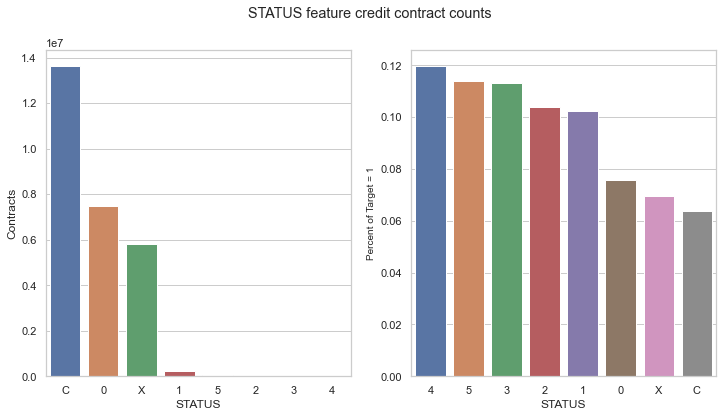

<IPython.core.display.Javascript object>

In [15]:
hc.plot_count(df_bureau_bal_analysis, "STATUS")

**Observation:**:

* STATUS feature as documented means: "Status of Credit Bureau loan during the month (active, closed, DPD0-30 (C means closed, X means status unknown, 0 means no DPD (DAYS PAS DUE), 1 means maximal did during month between 1-30, 2 means DPD 31-60, 5 means DPD 120+ or sold or written off )". As we can see there mostly closed status type of credits and most defaulters had 4 DPD level which meant that they were late more that 120+ days on their payment

# Data Wrangling

### Correlation with target

In [16]:
corrs_bureau_bal = df_bureau_bal_analysis.corr()[["TARGET"]].sort_values(
    by="TARGET", ascending=False
)
corrs_bureau_bal = corrs_bureau_bal.rename(columns={"TARGET": "target_corr"})
corrs_bureau_bal = corrs_bureau_bal.drop(["TARGET", "SK_ID_CURR", "SK_ID_BUREAU"])
corrs_bureau_bal

,target_corr
MONTHS_BALANCE,0.02777


<IPython.core.display.Javascript object>

# Bureau Balance Split Train/Test

In [17]:
%%time
df_bureau_bal_agg  = hc.aggregate_samples(df_bureau_bal.drop(columns=["SK_ID_BUREAU"]),"BUR_BAL_")

Wall time: 29.3 s


<IPython.core.display.Javascript object>

In [50]:
df_bureau_bal_agg.head(5)

,SK_ID_CURR,BUR_BAL_MONTHS_BALANCE_MEAN,BUR_BAL_MONTHS_BALANCE_MAX,BUR_BAL_MONTHS_BALANCE_MIN,BUR_BAL_MONTHS_BALANCE_SUM,BUR_BAL_STATUS_1_MEAN,BUR_BAL_STATUS_2_MEAN,BUR_BAL_STATUS_3_MEAN,BUR_BAL_STATUS_4_MEAN,BUR_BAL_STATUS_5_MEAN,BUR_BAL_STATUS_C_MEAN,BUR_BAL_STATUS_X_MEAN
0,100001.00000,-16.27907,0,-51,-2800,0.00581,0.00000,0.00000,0.00000,0.00000,0.63953,0.17442
1,100002.00000,-24.55455,0,-47,-2701,0.24545,0.00000,0.00000,0.00000,0.00000,0.20909,0.13636
2,100005.00000,-4.33333,0,-12,-91,0.00000,0.00000,0.00000,0.00000,0.00000,0.23810,0.09524
3,100010.00000,-46.00000,-2,-90,-3312,0.00000,0.00000,0.00000,0.00000,0.00000,0.72222,0.00000
4,100013.00000,-29.37391,0,-68,-6756,0.03043,0.00000,0.00000,0.00000,0.00000,0.44783,0.17826


<IPython.core.display.Javascript object>

In [18]:
%%time
# Splitting into train/test sets
df_train_sliced = df_application_train_proc[["SK_ID_CURR", "TARGET"]]
df_test_sliced = df_application_test_proc[["SK_ID_CURR"]]

df_bureau_bal_train = df_train_sliced.merge(df_bureau_bal_agg,how='left', on='SK_ID_CURR')
df_bureau_bal_test = df_test_sliced.merge(df_bureau_bal_agg,how='left', on='SK_ID_CURR')

Wall time: 391 ms


<IPython.core.display.Javascript object>

# Missing Values

In [19]:
missing_values_train = hc.missing_values(df_bureau_bal_train)
missing_values_train

,Missing Values,% of Total Values
BUR_BAL_MONTHS_BALANCE_MEAN,215280,70.00000
BUR_BAL_MONTHS_BALANCE_MAX,215280,70.00000
BUR_BAL_MONTHS_BALANCE_MIN,215280,70.00000
BUR_BAL_MONTHS_BALANCE_SUM,215280,70.00000
BUR_BAL_STATUS_1_MEAN,215280,70.00000
BUR_BAL_STATUS_2_MEAN,215280,70.00000
BUR_BAL_STATUS_3_MEAN,215280,70.00000
BUR_BAL_STATUS_4_MEAN,215280,70.00000
BUR_BAL_STATUS_5_MEAN,215280,70.00000
BUR_BAL_STATUS_C_MEAN,215280,70.00000


<IPython.core.display.Javascript object>

Noticeably there are significant amount of missing values on the train set. I will try to impute them with median value although most likely this dataset won't give us meaningful information for our models.

# Impute Missing Values

In [21]:
df_bureau_bal_train_imp, df_bureau_bal_test_imp = hc.impute_missing_num(
    df_bureau_bal_train, df_bureau_bal_test, df_bureau_bal_test.columns
)

<IPython.core.display.Javascript object>

In [22]:
hc.missing_values(df_bureau_bal_train_imp)

,Missing Values,% of Total Values


<IPython.core.display.Javascript object>

In [23]:
hc.missing_values(df_bureau_bal_test_imp)

,Missing Values,% of Total Values


<IPython.core.display.Javascript object>

# Scale

In [25]:
df_train_full_scaled, df_test_full_scaled = hc.scale_minmax(
    df_bureau_bal_train_imp,
    df_bureau_bal_test_imp,
)

<IPython.core.display.Javascript object>

In [26]:
df_train_full_scaled.head(5)

,BUR_BAL_MONTHS_BALANCE_MEAN,BUR_BAL_MONTHS_BALANCE_MAX,BUR_BAL_MONTHS_BALANCE_MIN,BUR_BAL_MONTHS_BALANCE_SUM,BUR_BAL_STATUS_1_MEAN,BUR_BAL_STATUS_2_MEAN,BUR_BAL_STATUS_3_MEAN,BUR_BAL_STATUS_4_MEAN,BUR_BAL_STATUS_5_MEAN,BUR_BAL_STATUS_C_MEAN,BUR_BAL_STATUS_X_MEAN,TARGET,SK_ID_CURR
0,0.73455,1.00000,0.51042,0.96542,0.27944,0.00000,0.00000,0.00000,0.00000,0.20909,0.13636,1,100002.00000
1,0.74635,1.00000,0.40625,0.96560,0.00000,0.00000,0.00000,0.00000,0.00000,0.41037,0.08421,0,100003.00000
2,0.74635,1.00000,0.40625,0.96560,0.00000,0.00000,0.00000,0.00000,0.00000,0.41037,0.08421,0,100004.00000
3,0.74635,1.00000,0.40625,0.96560,0.00000,0.00000,0.00000,0.00000,0.00000,0.41037,0.08421,0,100006.00000
4,0.74635,1.00000,0.40625,0.96560,0.00000,0.00000,0.00000,0.00000,0.00000,0.41037,0.08421,0,100007.00000


<IPython.core.display.Javascript object>

# Baseline model

In [27]:
X_train_full = df_train_full_scaled.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_full = df_test_full_scaled.drop(columns=["SK_ID_CURR"])

y_train_full = df_train_full_scaled["TARGET"]

<IPython.core.display.Javascript object>

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=RANDOM_STATE,
)

<IPython.core.display.Javascript object>

### LGBM

In [29]:
LGBM_clsf = LGBMClassifier(
    class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1, metric="auc"
)

<IPython.core.display.Javascript object>

In [30]:
%%time
LGBM_clsf.fit(X_train, y_train)

Wall time: 1.84 s


LGBMClassifier(class_weight='balanced', metric='auc', random_state=0)

<IPython.core.display.Javascript object>

In [31]:
y_pred_train, y_pred_val = hc.get_binary_predictions(LGBM_clsf, X_train, X_val)
y_pred_train_prob, y_pred_val_prob = hc.get_prob_predictions(LGBM_clsf, X_train, X_val)

accuracy_score_train, accuracy_score_val = hc.get_accuracy_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
precision_score_train, precision_score_val = hc.get_precision_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
recall_score_train, recall_score_val = hc.get_recall_scores(
    y_train, y_pred_train, y_val, y_pred_val
)
roc_auc_score_train, roc_auc_score_val = hc.get_roc_auc_score(
    y_train, y_pred_train_prob, y_val, y_pred_val_prob
)

Training accuracy is 0.8479399043933531
Validation accuracy is 0.8400078044973416
Training precision is 0.158705461334993
Validation precision is 0.11364717070851164
Training recall is 0.2054380664652568
Validation recall is 0.14441087613293052
Training ROC AUC is 0.5985750638955415
Validation ROC AUC is 0.54071633665308


<IPython.core.display.Javascript object>

In [32]:
df_scores = pd.DataFrame()

dict_scores = {
    "Model": ["LGBM"],
    "Notes": ["Baseline With All Features"],
    "Accuracy_train": [accuracy_score_train],
    "Accuracy_val": [accuracy_score_val],
    "Precision_train": [precision_score_train],
    "Precision_val": [precision_score_val],
    "Recall_train": [recall_score_train],
    "Recall_val": [recall_score_val],
    "ROC_AUC_train": [roc_auc_score_train],
    "ROC_AUC_val": [roc_auc_score_val],
}
df_scores = df_scores.append(pd.DataFrame(dict_scores))
df_scores

,Model,Notes,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val,ROC_AUC_train,ROC_AUC_val
0,LGBM,Baseline With All Features,0.84794,0.84001,0.15871,0.11365,0.20544,0.14441,0.59858,0.54072


<IPython.core.display.Javascript object>

High amout of missing values and not very impactful features as expected get very low LGBM scores.

# Saving Final DataFrames

In [33]:
df_scores.to_csv("data/bureau_bal_scores.csv", index=False)

<IPython.core.display.Javascript object>

In [63]:
df_train_full_scaled.drop(columns=["TARGET"]).to_csv(
    "data/bureau_bal_train_proc.csv", index=False
)
df_test_full_scaled.to_csv("data/bureau_bal_test_proc.csv", index=False)

<IPython.core.display.Javascript object>

In [64]:
pd.read_csv("data/bureau_bal_train_proc.csv").head(5)

,BUR_BAL_MONTHS_BALANCE_MEAN,BUR_BAL_MONTHS_BALANCE_MAX,BUR_BAL_MONTHS_BALANCE_MIN,BUR_BAL_MONTHS_BALANCE_SUM,BUR_BAL_STATUS_1_MEAN,BUR_BAL_STATUS_2_MEAN,BUR_BAL_STATUS_3_MEAN,BUR_BAL_STATUS_4_MEAN,BUR_BAL_STATUS_5_MEAN,BUR_BAL_STATUS_C_MEAN,BUR_BAL_STATUS_X_MEAN,SK_ID_CURR
0,0.73455,1.00000,0.51042,0.96542,0.27944,0.00000,0.00000,0.00000,0.00000,0.20909,0.13636,100002.00000
1,0.74635,1.00000,0.40625,0.96560,0.00000,0.00000,0.00000,0.00000,0.00000,0.41037,0.08421,100003.00000
2,0.74635,1.00000,0.40625,0.96560,0.00000,0.00000,0.00000,0.00000,0.00000,0.41037,0.08421,100004.00000
3,0.74635,1.00000,0.40625,0.96560,0.00000,0.00000,0.00000,0.00000,0.00000,0.41037,0.08421,100006.00000
4,0.74635,1.00000,0.40625,0.96560,0.00000,0.00000,0.00000,0.00000,0.00000,0.41037,0.08421,100007.00000


<IPython.core.display.Javascript object>